In [1]:
import torch
import pandas as pd
import gc
from src.final_models import PivotBaseline, ZeroShotNeutralizer, SyntheticNeutralizer, FewShotNeutralizer
from src.evaluate import Evaluator

# 1. Load the Gold Test Data
# Ensure you ran 'src/data_collection/create_pseudo_gold.py' first!
test_df = pd.read_csv("data/processed/test_chinese_gold.csv")
inputs = test_df["Chinese_Biased"].tolist()
gold_refs = test_df["Chinese_Neutral_Gold"].tolist()

print(f"Loaded {len(inputs)} test cases.")

# Dictionary to store outputs from each model
model_outputs = {}

# Define the models we want to test
# We use a list of classes so we can instantiate -> run -> delete to save RAM
model_classes = [
    ("Baseline (Pivot)", PivotBaseline),
    ("Model 2 (ZeroShot)", ZeroShotNeutralizer),
    ("Model 3 (Synthetic)", SyntheticNeutralizer),
    ("Model 4 (FewShot)", FewShotNeutralizer),
]

for name, ModelClass in model_classes:
    print(f"\n🚀 Running Inference for: {name}...")

    try:
        # A. Initialize Model
        model_instance = ModelClass()

        # B. Generate
        # Using batch_debias if available, else loop
        outputs = [model_instance.debias(text) for text in inputs]
        model_outputs[name] = outputs

        # C. Cleanup (CRITICAL for GPU Memory)
        del model_instance
        torch.cuda.empty_cache()
        gc.collect()

    except Exception as e:
        print(f"❌ Failed to run {name}: {e}")
        model_outputs[name] = ["Error"] * len(inputs)

print("\n✅ Inference Complete. Starting Evaluation...")

✅ Loaded local font: src/misc/SimHei.ttf
Loaded 100 test cases.

🚀 Running Inference for: Baseline (Pivot)...
[PivotBaseline] Initializing on cuda...
Loading ZH->EN Translator...
Loading EN->ZH Translator...
Loading English Neutralizer...
Initializing mBART on cuda...


The tokenizer you are loading from 'models/mbart_neutralizer_en_v1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.



🚀 Running Inference for: Model 2 (ZeroShot)...
[ZeroShotNeutralizer] Initializing on cuda...
Initializing mBART on cuda...


The tokenizer you are loading from 'models/mbart_neutralizer_en_v1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.



🚀 Running Inference for: Model 3 (Synthetic)...
[SyntheticNeutralizer] Initializing on cuda...
Initializing mBART on cuda...


The tokenizer you are loading from 'models/mbart_neutralizer_zh_synthetic' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.



🚀 Running Inference for: Model 4 (FewShot)...
[FewShotNeutralizer] Initializing on cuda...
Initializing mBART on cuda...


The tokenizer you are loading from 'models/mbart_neutralizer_zh_1percent' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.



✅ Inference Complete. Starting Evaluation...


In [ ]:
print("\n💾 Exporting model outputs for manual inspection...")

# 1. Create a dictionary with the static columns
inspection_data = {
    "Original_Biased": inputs,
    "Gold_Reference": gold_refs
}

# 2. Add each model's predictions dynamically
for model_name, predictions in model_outputs.items():
    # Handle cases where a model might have failed
    if len(predictions) != len(inputs):
        print(f"Warning: {model_name} output length mismatch. Padding with blanks.")
        predictions = predictions + [""] * (len(inputs) - len(predictions))
        
    inspection_data[f"Pred_{model_name}"] = predictions

# 3. Create DataFrame and Save
df_inspection = pd.DataFrame(inspection_data)
output_path = "report_data/manual_inspection.csv"
df_inspection.to_csv(output_path, index=False, encoding='utf-8-sig') # utf-8-sig for proper Excel Chinese rendering

print(f"✅ Saved manual inspection file to: {output_path}")

In [2]:
# 1. Initialize Evaluator (Loads BERT Judge + GPT2)
evaluator = Evaluator()

results_table = []

for model_name, predictions in model_outputs.items():
    print(f"\n📊 Evaluating {model_name}...")

    # Check for empty/error outputs
    if not predictions or predictions[0] == "Error":
        continue

    # A. Style Accuracy (Did it remove bias?)
    acc = evaluator.get_style_accuracy(predictions)

    # B. Content Preservation (Did it keep meaning?)
    # Compare Prediction vs Original Biased Input (or Gold Neutral if you prefer)
    # Comparing to Input checks if we kept the *topic*.
    # Comparing to Gold checks if we matched the *reference*.
    # Standard Style Transfer usually compares to INPUT for preservation.
    bert_score = evaluator.get_bert_score(predictions, inputs)

    # C. Fluency (Is it natural Chinese?)
    ppl = evaluator.get_perplexity(predictions)

    # D. Composite Score (Geometric Mean)
    # We use 100/PPL scaling just to make the number readable in the table (e.g., 0.45 instead of 0.004)
    # Formula: (Acc * BERT * (100/PPL))^(1/3)
    composite = evaluator.calculate_composite_score(acc, bert_score, ppl)

    results_table.append(
        {
            "Model": model_name,
            "Style Acc (↑)": f"{acc:.2%}",
            "Content Sim (↑)": f"{bert_score:.3f}",
            "Fluency PPL (↓)": f"{ppl:.2f}",
            "Composite Score": f"{composite:.3f}",
        }
    )

Initializing Evaluators on cuda...

📊 Evaluating Baseline (Pivot)...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.



📊 Evaluating Model 2 (ZeroShot)...

📊 Evaluating Model 3 (Synthetic)...

📊 Evaluating Model 4 (FewShot)...


In [3]:
print("\n" + "=" * 40)
print(" FINAL RESEARCH RESULTS ")
print("=" * 40)
df_results = pd.DataFrame(results_table)
display(df_results)

# Save for your paper
df_results.to_csv("report_data/final_metrics_table.csv", index=False)

# Optional: Show a few qualitative examples
print("\n--- Qualitative Analysis (First 3 Examples) ---")
for i in range(3):
    print(f"\nInput: {inputs[i]}")
    for model_name, preds in model_outputs.items():
        print(f"[{model_name}]: {preds[i]}")


 FINAL RESEARCH RESULTS 


,Model,Style Acc (↑),Content Sim (↑),Fluency PPL (↓),Composite Score
0,Baseline (Pivot),72.00%,0.835,36688.70,0.025
1,Model 2 (ZeroShot),53.00%,0.950,23755.12,0.028
2,Model 3 (Synthetic),62.00%,0.964,25694.13,0.029
3,Model 4 (FewShot),53.00%,0.950,23755.12,0.028



--- Qualitative Analysis (First 3 Examples) ---

Input: 其轴心是1940年签署三方条约后建立的,奉行强大的军国主义、种族主义和民族主义意识形态,奉行反共政策。
[Baseline (Pivot)]: 其轴心是在签署三方条约和反共政策之后于1940年确立的。
[Model 2 (ZeroShot)]: 其轴心是1940年签署三方条约后建立的,奉行强大的军国主义、种族主义和民族主义意识形态,并奉行的反共政策。
[Model 3 (Synthetic)]: 其轴心是1940年签署三方条约后建立的,奉行反共政策。
[Model 4 (FewShot)]: 其轴心是1940年签署三方条约后建立的,奉行强大的军国主义、种族主义和民族主义意识形态,并奉行的反共政策。

Input: 住在Jerusalim的Pisgat ze'ev社区。
[Baseline (Pivot)]: 他住在耶鲁沙林的皮斯加特社区
[Model 2 (ZeroShot)]: 住在Jerusalem,住在Pisgat ze'ev社区。
[Model 3 (Synthetic)]: 住在Jerusalim的Pisgat ze'ev社区。
[Model 4 (FewShot)]: 住在Jerusalem,住在Pisgat ze'ev社区。

Input: 包括瑞安(略微是他们的高年级)的球员在1992年5月帮助俱乐部赢得了青春杯,
[Baseline (Pivot)]: 包括瑞安(略微高龄)在内, 协助俱乐部在1992年5月赢得青年杯。
[Model 2 (ZeroShot)]: 包括瑞安(略微是他们的高年级)的一些球员在1992年5月帮助俱乐部赢得了青春杯,
[Model 3 (Synthetic)]: 包括瑞安(略微是他们的高年级)的球员在1992年5月帮助俱乐部赢得了青春杯,
[Model 4 (FewShot)]: 包括瑞安(略微是他们的高年级)的一些球员在1992年5月帮助俱乐部赢得了青春杯,


In [5]:
import pandas as pd
from tqdm import tqdm

print("\n🔍 Generating Granular Inspection Report (Per-Example Metrics)...")
print("This may take a minute as we score each example individually.\n")

detailed_rows = []

# Loop through each test case (N=100)
for i in tqdm(range(len(inputs)), desc="Scoring Examples"):
    
    # 1. Start with the ground truth data
    row_data = {
        "ID": i,
        "Original_Input": inputs[i],
        "Gold_Reference": gold_refs[i]
    }
    
    # 2. For each model, calculate granular scores
    for model_name, predictions in model_outputs.items():
        pred_text = predictions[i]
        
        # Handle failures
        if not pred_text or pred_text == "Error":
            row_data[f"{model_name}_Output"] = "Error"
            row_data[f"{model_name}_Style"] = 0.0
            row_data[f"{model_name}_Content"] = 0.0
            row_data[f"{model_name}_Fluency"] = 99999.0
            continue
            
        # --- Calculate Metrics for this SINGLE example ---
        
        # A. Style: Returns 1.0 if Neutral, 0.0 if Biased (Accuracy on a batch of 1)
        # We wrap strings in [] because evaluators expect lists
        style_score = evaluator.get_style_accuracy([pred_text])
        
        # B. Content: Similarity between Prediction and INPUT (Preservation)
        content_score = evaluator.get_bert_score([pred_text], [inputs[i]])
        
        # C. Fluency: Perplexity
        ppl_score = evaluator.get_perplexity([pred_text])
        
        # Store Raw Data
        row_data[f"{model_name}_Output"] = pred_text
        
        # Store Metrics
        # Style is effectively binary here (0 or 1)
        row_data[f"{model_name}_Style"] = int(style_score == 1.0) 
        row_data[f"{model_name}_Content"] = round(content_score, 3)
        row_data[f"{model_name}_Fluency"] = round(ppl_score, 1)
        
        # Optional: Calculate Composite Score per row for easy sorting
        # Formula: (Style * Content * (100/PPL))^(1/3)
        # We clamp PPL to min 1 to avoid division by zero
        safe_ppl = max(ppl_score, 1.0)
        composite = (style_score * content_score * (100 / safe_ppl)) ** (1/3)
        row_data[f"{model_name}_Composite"] = round(composite, 3)

    detailed_rows.append(row_data)

# 3. Create DataFrame and Save
df_granular = pd.DataFrame(detailed_rows)

# Reorder columns to group by model (Optional, for readability)
# Starts with ID, Input, Gold, then adds all model columns
cols = ["ID", "Original_Input", "Gold_Reference"]
for name in model_outputs.keys():
    cols.extend([
        f"{name}_Output", 
        f"{name}_Style", 
        f"{name}_Content", 
        f"{name}_Fluency", 
        f"{name}_Composite"
    ])
    
# Filter only existing columns (just in case)
df_granular = df_granular[[c for c in cols if c in df_granular.columns]]

output_file = "report_data/granular_inspection.csv"
df_granular.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"\n✅ Detailed granular report saved to: {output_file}")
print("   Open this in Excel to sort by 'Composite' or filter for 'Style=0' (failures).")
display(df_granular.head(3))


🔍 Generating Granular Inspection Report (Per-Example Metrics)...
This may take a minute as we score each example individually.



Scoring Examples: 100%|██████████| 100/100 [14:22<00:00,  8.62s/it]


✅ Detailed granular report saved to: report_data/granular_inspection.csv
   Open this in Excel to sort by 'Composite' or filter for 'Style=0' (failures).


,ID,Original_Input,Gold_Reference,Baseline (Pivot)_Output,Baseline (Pivot)_Style,Baseline (Pivot)_Content,Baseline (Pivot)_Fluency,Baseline (Pivot)_Composite,Model 2 (ZeroShot)_Output,Model 2 (ZeroShot)_Style,Model 2 (ZeroShot)_Content,Model 2 (ZeroShot)_Fluency,Model 2 (ZeroShot)_Composite,Model 3 (Synthetic)_Output,Model 3 (Synthetic)_Style,Model 3 (Synthetic)_Content,Model 3 (Synthetic)_Fluency,Model 3 (Synthetic)_Composite
0,0,"其轴心是1940年签署三方条约后建立的,奉行强大的军国主义、种族主义和民族主义意识形态,奉行...","轴心是1940年签署三方条约后建立的,奉行强烈的军国主义和民族主义意识形态,奉行反共政策。",其轴心是在签署三方条约和反共政策之后于1940年确立的。,1,0.802,8192.9,0.214,"其轴心是1940年签署三方条约后建立的,奉行强大的军国主义、种族主义和民族主义意识形态,并奉...",0,0.984,12199.3,0.000,"其轴心是1940年签署三方条约后建立的,奉行反共政策。",1,0.874,4552.7,0.268
1,1,住在Jerusalim的Pisgat ze'ev社区。,"内阴是已婚,有两个孩子, 住在东耶鲁沙隆的Pisgat Ze'ev定居点",他住在耶鲁沙林的皮斯加特社区,1,0.692,5249.6,0.236,"住在Jerusalem,住在Pisgat ze'ev社区。",1,0.933,1409.9,0.405,住在Jerusalim的Pisgat ze'ev社区。,1,1.000,2350.3,0.349
2,2,"包括瑞安(略微是他们的高年级)的球员在1992年5月帮助俱乐部赢得了青春杯,","这些球员后来帮助俱乐部在1992年5月赢得了青春杯,Beckham在决赛的第二段中得分,与水...","包括瑞安(略微高龄)在内, 协助俱乐部在1992年5月赢得青年杯。",0,0.847,3107.6,0.000,"包括瑞安(略微是他们的高年级)的一些球员在1992年5月帮助俱乐部赢得了青春杯,",0,0.984,2368.4,0.000,"包括瑞安(略微是他们的高年级)的球员在1992年5月帮助俱乐部赢得了青春杯,",0,1.000,3001.9,0.000


✅ Loaded local font: src/misc/SimHei.ttf
Loading Model 2 (Zero Shot)...
[ZeroShotNeutralizer] Initializing on cuda...
Initializing mBART on cuda...


The tokenizer you are loading from 'models/mbart_neutralizer_en_v1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
/home/ubuntu/miniconda3/envs/deeplearning-gpu/lib/python3.10/site-packages/transformers/generation/utils.py:1733: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/home/ubuntu/miniconda3/envs/deeplearning-gpu/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 28608 (\N{CJK UNIFIED IDEOGRAPH-6FC0}) missing from font(s) DejaVu Sans.

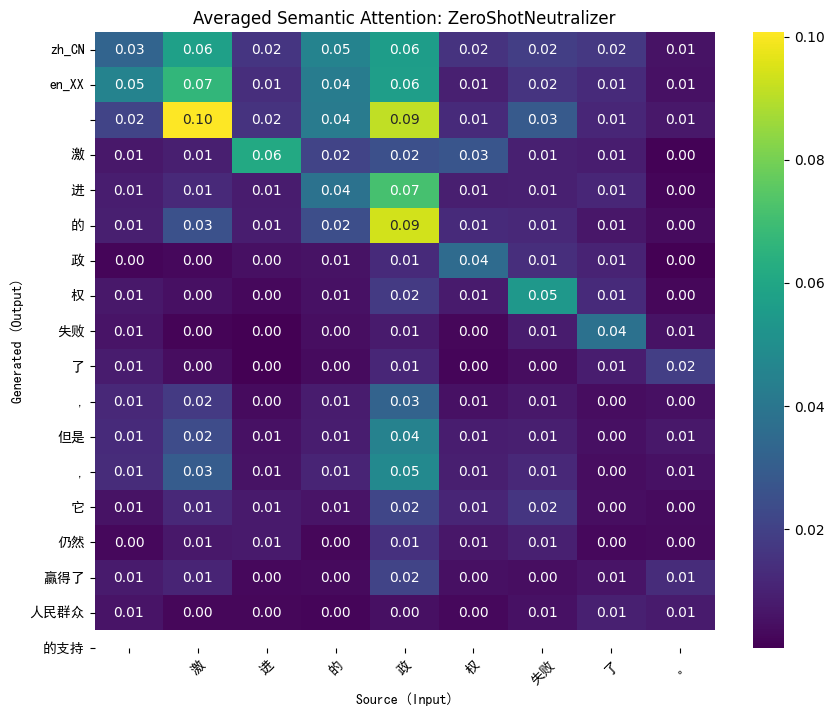

Loading Model 3 (Synthetic)...
[SyntheticNeutralizer] Initializing on cuda...
Initializing mBART on cuda...


The tokenizer you are loading from 'models/mbart_neutralizer_zh_synthetic' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
/home/ubuntu/miniconda3/envs/deeplearning-gpu/lib/python3.10/site-packages/transformers/generation/utils.py:1733: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/home/ubuntu/miniconda3/envs/deeplearning-gpu/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 28608 (\N{CJK UNIFIED IDEOGRAPH-6FC0}) missing from font(s) DejaV

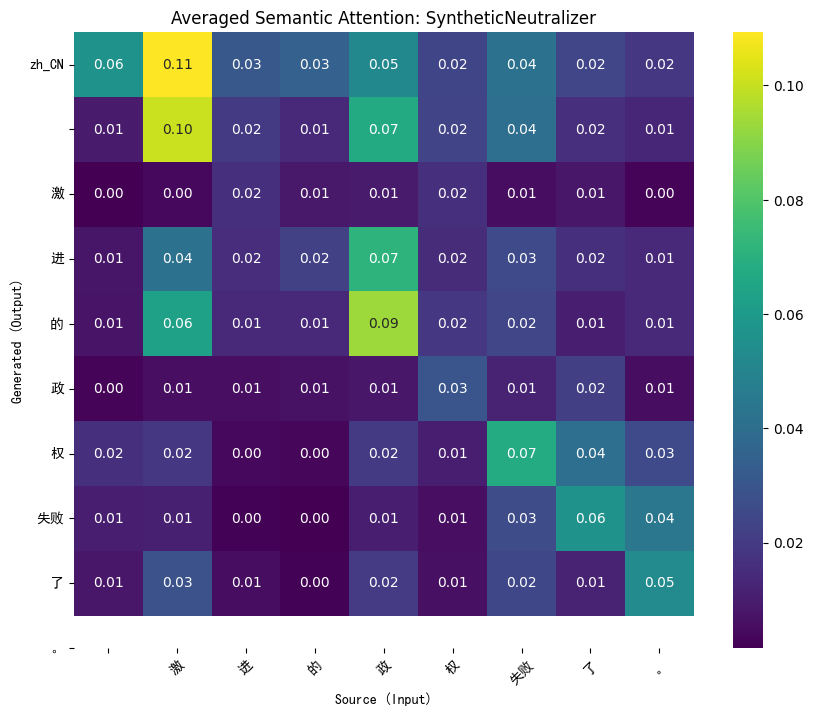

In [ ]:
from src import plot_attention_averaged
from src.final_models import ZeroShotNeutralizer, SyntheticNeutralizer
# Compare the two models on a specific bias phrase
# "The radical regime failed." -> "激进的政权失败了。"
test_phrase = "激进的政权失败了。"

print("Loading Model 2 (Zero Shot)...")
model2 = ZeroShotNeutralizer()
plot_attention_averaged(model2, test_phrase)
del model2 # Free Memory

print("Loading Model 3 (Synthetic)...")
model3 = SyntheticNeutralizer()
plot_attention_averaged(model3, test_phrase)
del model3